**Tasks**
- We have a bunch of graphs and we want to predict something with them. Ideally similar graphs have similar prediction labels.

# Graph prediction

**Predicting on graphs**  
We want to predict using all the node embeddings from a graph. Therefore, want to *aggregate* the embeddings of the nodes in some way. We define a function $f_p$ which maps node embeddings $\{h_{1}, ... h_{|V|}\}$ to a graph embedding $h_G$. After computing this embedding we can put it in a $\text{MLP}$ model and output our final labels

We can use different poolings:
1. Global mean pooling -- Used when number of nodes  doesn't matter as much. 
2. Global max pooling
3. Global sum pooling -- Used when the structure of the graph matters more.

**Problem with pooling**  
Large graphs might use too much information (especially prevalent in large graphs) and structural properties of the graphs are lost. A solution to this is *graph clustering* where we cluster graphs step by step until we reach a desirable size after which we use normal pooling methods. This approach is inspired by the idea that communities are found in graphs and they cluster together.

Paper: [Hierarchical Graph Representation Learning with
Differentiable Pooling](https://arxiv.org/pdf/1806.08804.pdf) (photo from here)

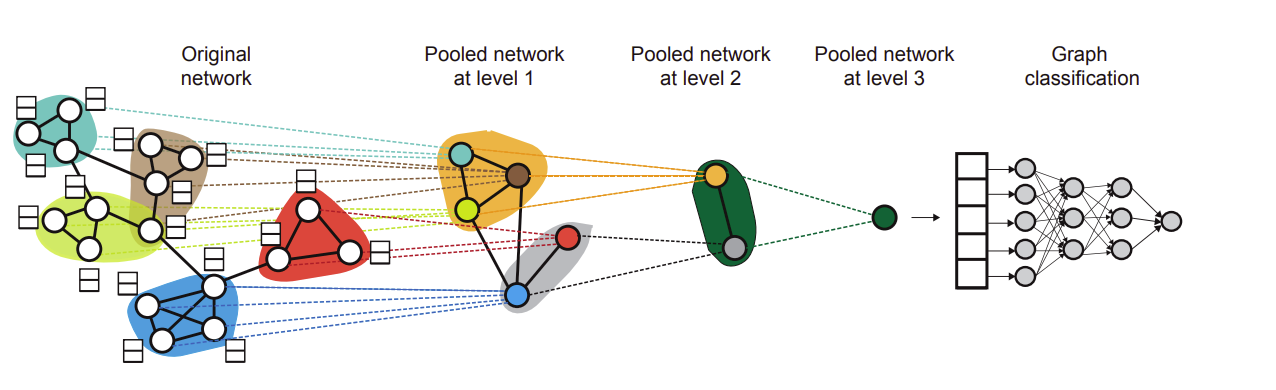

# Code

In [64]:
import copy
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os, sys


from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric.datasets import TUDataset
import torch_geometric.transforms as pyg_T
from torch_geometric.utils import to_networkx, from_networkx
from torch_geometric.loader import DataLoader

from ogb.graphproppred import PygGraphPropPredDataset, Evaluator


from tqdm import tqdm

In [59]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load data using OGB
- https://arxiv.org/pdf/2005.00687.pdf
- https://ogb.stanford.edu/docs/graphprop/

We are using molecules. About input data:

Input node features are 9-dimensional, containing atomic number and chirality, as well as other additional atom features such as formal charge and whether the atom is in the ring or not.

For processing these raw features ogb provides AtomEncoder and BondEncoder.
```python
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder
atom_encoder = AtomEncoder(emb_dim = 100)
bond_encoder = BondEncoder(emb_dim = 100)

atom_emb = atom_encoder(x) # x is input atom feature
edge_emb = bond_encoder(edge_attr) # edge_attr is input edge feature
```

In [366]:
dataset_name = 'ogbg-molclintox' # molbace  # molbbbp
dataset = PygGraphPropPredDataset(root =  os.path.join('..', 'data', 'tmp', dataset_name), name = dataset_name) 

In [367]:
print(dataset.meta_info)

num tasks                                                                2
eval metric                                                         rocauc
download_name                                                      clintox
version                                                                  1
url                      http://snap.stanford.edu/ogb/data/graphproppre...
add_inverse_edge                                                      True
data type                                                              mol
has_node_attr                                                         True
has_edge_attr                                                         True
task type                                            binary classification
num classes                                                              2
split                                                             scaffold
additional node files                                                 None
additional edge files    

In [368]:
print_dataset(dataset)

Dataset: PygGraphPropPredDataset(1477):
Number of graphs: 1477
Number of features: 9
Number of classes: 2


In [369]:
# Check number of positive / negatives
#np.unique([graph.y for graph in dataset], return_counts=True)

In [370]:
split_idx = dataset.get_idx_split() 
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True)
val_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False)

In [371]:
dataset[0].y[0]

tensor([1, 0])

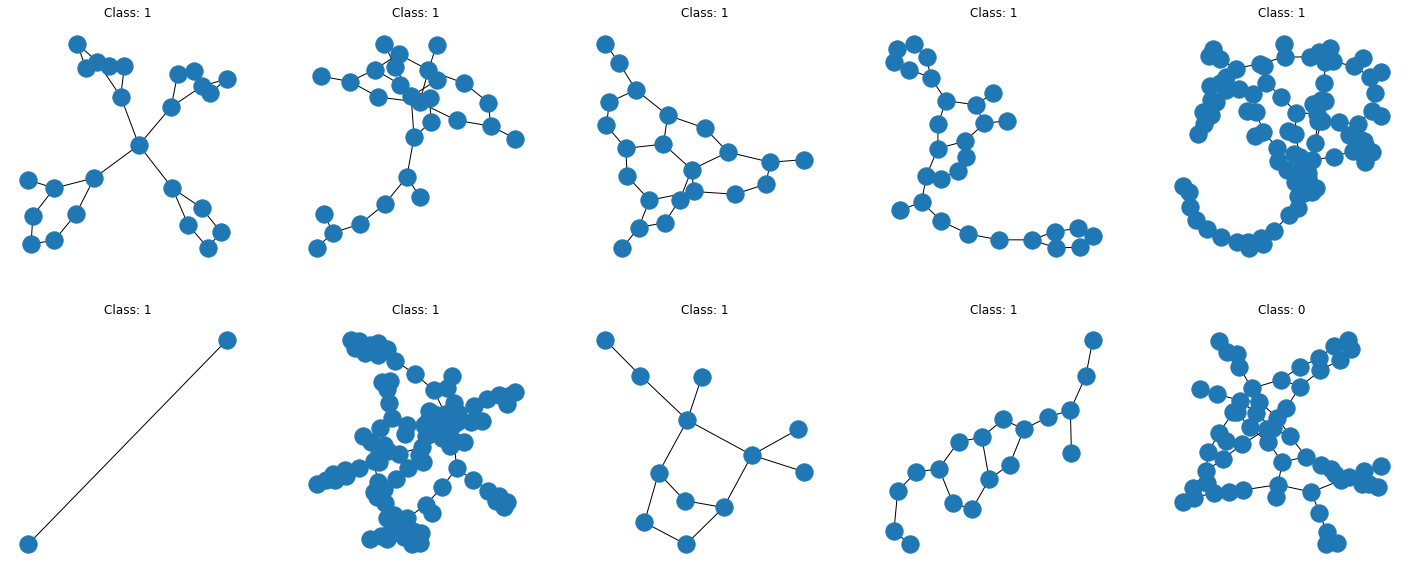

In [372]:
# Let's look at some graphs

samples = np.random.randint(0, len(dataset), 10)
plt.figure(figsize = (25, 10))
for i, s in enumerate(samples):
    graph = dataset[s]
    G = to_networkx(graph, to_undirected=True)
    plt.subplot(2, 5, i + 1)
    plt.title(f"Class: {graph.y[0][0].item()}")
    nx.draw_spring(G)
    

## Models

Let's write a simple model with pooling as our way to aggregate nodes

In [373]:
from torch_geometric.nn import global_mean_pool, global_add_pool, global_max_pool

In [374]:
class GCNGraph(torch.nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, dropout = .2, negative_slope = .2, pool = global_mean_pool):
        super(GCNGraph, self).__init__()
        
        # Load encoders for Atoms in molecule graphs.
        # This transforms initial features into embeddings
        self.node_encoder = AtomEncoder(hidden_dim)

        # Node embedding model
        # Note that the input_dim and output_dim are set to hidden_dim
        
        # List of GCN conv layers layers
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            self.convs.append(GCNConv(in_channels=hidden_dim, out_channels=hidden_dim))
            
        self.pool = pool # The pooling layer
        
        # Post processing
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)
        
        # Extras
        self.num_layers = num_layers
        self.dropout = dropout
        self.negative_slope = negative_slope

    def forward(self, batch):
        x, edge_index, batch = batch.x, batch.edge_index, batch.batch
        
        # Embed raw features
        x = self.node_encoder(x)
        
        for i in range(self.num_layers - 1):
            x = self.convs[i](x, edge_index)
            x = F.leaky_relu(x, negative_slope=self.negative_slope)
            if self.training:
                x = F.dropout(x, p=self.dropout)
        # Last layer
        x = self.convs[-1](x, edge_index)
        # Pool the results
        x = self.pool(x, batch)
        # Classify 
        out = self.classifier(x)
        
        return out

## Batch training

In [375]:
def train(model, train_loader, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device) # Put batch on the device
        
        
        # Skip batches with 1 node
        if batch.x.shape[0] == 1:
            continue
            
        # Filter out nans    
        is_labeled = batch.y == batch.y
        
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out[is_labeled], batch.y[is_labeled].type_as(out))
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
        
    return train_loss

@torch.no_grad()
def test(model, loader, evaluator, device):
    model.eval()
    y_true = []
    y_pred = []
    
    for batch in loader:
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            continue
        
        # Add predictions
        out = model(batch)
        y_true.append(batch.y.detach().cpu())
        y_pred.append(out.detach().cpu())
    
    # y_true, y_pred are list of lists. We flatten them
    
    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    input_dict = {"y_true": y_true, "y_pred": y_pred}
    res = evaluator.eval(input_dict)
    
    return res

In [376]:
# Try different pooling layers

model = GCNGraph(256, dataset.num_tasks, 2, dropout=.4, pool=global_max_pool)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = .001)
loss_function = F.binary_cross_entropy_with_logits

evaluator = Evaluator(name=dataset_name)

In [377]:
epochs = 10

metric = dataset.eval_metric

for epoch in range(epochs):    
    loss_train = train(model, train_loader, optimizer, loss_function, device)
    train_result = test(model, train_loader, evaluator, device)
    val_result = test(model, val_loader, evaluator, device)
    
    metric_train = train_result[metric]
    metric_val = val_result[metric]
    
    if epoch % 1 == 0:
        print(f"{epoch=} \t {metric=} \t {loss_train=:2f} | {metric_train=:.2f} \t {metric_val=:.2f}")

epoch=0 	 metric='rocauc' 	 loss_train=11.759053 | metric_train=0.67 	 metric_val=0.55
epoch=1 	 metric='rocauc' 	 loss_train=9.487538 | metric_train=0.75 	 metric_val=0.70
epoch=2 	 metric='rocauc' 	 loss_train=9.443297 | metric_train=0.81 	 metric_val=0.86
epoch=3 	 metric='rocauc' 	 loss_train=8.599201 | metric_train=0.86 	 metric_val=0.91
epoch=4 	 metric='rocauc' 	 loss_train=7.682304 | metric_train=0.87 	 metric_val=0.92
epoch=5 	 metric='rocauc' 	 loss_train=7.409397 | metric_train=0.90 	 metric_val=0.94
epoch=6 	 metric='rocauc' 	 loss_train=7.347175 | metric_train=0.88 	 metric_val=0.94
epoch=7 	 metric='rocauc' 	 loss_train=7.143834 | metric_train=0.90 	 metric_val=0.94
epoch=8 	 metric='rocauc' 	 loss_train=6.705860 | metric_train=0.92 	 metric_val=0.94
epoch=9 	 metric='rocauc' 	 loss_train=6.217155 | metric_train=0.92 	 metric_val=0.96


In [378]:
test_result = test(model, test_loader, evaluator, device)
test_result

{'rocauc': 0.8802132207277656}